In [2]:
import pymc as pm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder

from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin


from sklearn.linear_model import Ridge


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Tests and Preprocessing

In [3]:

df = pd.read_csv('../../data/raw/Retail_Sales_Data.csv' )

# Drop 'value', 'volume', and 'description' columns if not already done
df = df.drop(columns=['value', 'volume', 'description'], errors='ignore')


In [ ]:
# Iterate over each competitor's promo and regular price columns
for i in range(1, 11):  
    promo_column = f'competition_{i}_promo_price'
    regular_column = f'competition_{i}_regular_price'
    
    # Replace NaN in promo price with the value from the corresponding regular price
    df[promo_column].fillna(df[regular_column], inplace=True)


/tmp/ipykernel_124079/1355028088.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[promo_column].fillna(df[regular_column], inplace=True)


In [5]:
df = df[df['retailer'] == 'retail2']

# Drop the 'retailer' column as it will contain only one value
df = df.drop(columns=['retailer'])

label_encoder = LabelEncoder()
df['product_encoded'] = label_encoder.fit_transform(df['product'])

# Drop the original 'product' column, since we've encoded it
df = df.drop(columns=['product'])

# Display the first few rows to confirm encoding
print(df.head())

      store_id  week  regular_price  competition_1_regular_price  \
5200         1     1      16.428715                    16.710216   
5201         1     1      15.962498                    16.218075   
5202         1     1       8.279885                     8.257651   
5203         1     1      17.731646                    17.486776   
5204         1     1      18.002621                    18.518599   

      competition_2_regular_price  competition_3_regular_price  \
5200                    16.869853                    15.690662   
5201                    16.062447                    16.012069   
5202                     8.100983                     8.436745   
5203                    17.247836                    18.239302   
5204                    17.135075                    18.579418   

      competition_4_regular_price  competition_5_regular_price  \
5200                    17.044447                    15.906068   
5201                    16.404512                    15.838903

In [6]:
X = df.drop(columns=['quantity'])
y = df['quantity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Align columns in case train and test sets have different one-hot encoded columns
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Ensure all columns are numeric to avoid dtype issues
X_train = X_train.apply(pd.to_numeric, errors='coerce').fillna(0)
X_test = X_test.apply(pd.to_numeric, errors='coerce').fillna(0)

# Diagnostic: Check for any remaining non-numeric columns
print("Data types in X_train after processing:", X_train.dtypes.value_counts())

Data types in X_train after processing: float64    22
int64       3
Name: count, dtype: int64


In [8]:
import numpy as np
import os

# Define the directory where the priors were saved
save_directory = os.path.expanduser('~/Ferrero_Tech_Assesment/data/processed')

# Load the saved coefficients and intercepts
file_path = os.path.join(save_directory, 'linear_model_priors.npz')
data = np.load(file_path)

linear_coefs_original = data['coefs_original']
linear_intercept_original = data['intercept_original']

linear_coefs_normalized = data['coefs_normalized']
linear_intercept_normalized = data['intercept_normalized']

# Now you can use these priors in your Bayesian model

In [13]:
# Convert all columns in X_train and X_test to float64
X_train = X_train.astype(float)
X_test = X_test.astype(float)

# Verify data types
print("Data types in X_train after final conversion:", X_train.dtypes.value_counts())
print("Data types in X_test after final conversion:", X_test.dtypes.value_counts())

with pm.Model() as bayesian_model:
    # Priors
    intercept = pm.Normal('intercept', mu=10, sigma=2)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Define coefficients for each feature
    coefs = pm.Normal('coefs', mu=0, sigma=1, shape=X_train.shape[1])

    # Linear regression model
    y_pred = intercept + pm.math.dot(X_train.values, coefs)

    # Likelihood
    y_obs = pm.Normal('y_obs', mu=y_pred, sigma=sigma, observed=y_train.values)

    # Sampling with reduced draws and chains for speed, using the Metropolis step method
    step = pm.Metropolis()
    trace = pm.sample(draws=500, tune=500, chains=2, step=step)



Data types in X_train after final conversion: float64    25
Name: count, dtype: int64
Data types in X_test after final conversion: float64    25
Name: count, dtype: int64


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [intercept]
>Metropolis: [sigma]
>Metropolis: [coefs]


Output()

/home/cian/Ferrero_Tech_Assesment/new_venv/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


/home/cian/Ferrero_Tech_Assesment/new_venv/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 22 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [ ]:
# Predictions
with bayesian_model:
    post_pred = pm.sample_posterior_predictive(trace)

# Retrieve y_pred_samples
y_pred_samples = post_pred['posterior_predictive']['y_obs']

# Check the shape of y_pred_samples
print("Shape of y_pred_samples:", y_pred_samples.shape)

# Take the mean across the first two axes (number of chains and number of samples)
y_pred = y_pred_samples.mean(axis=(0, 1))  # Now this should give you predictions of shape (2912,)

# Ensure that the predictions align with y_test
print("Length of y_test:", len(y_test))
print("Length of y_pred:", len(y_pred))


y_pred = y_pred[:len(y_test)]

# Performance metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Bayesian Model - Mean Squared Error (MSE): {mse}")
print(f"Bayesian Model - Mean Absolute Error (MAE): {mae}")
print(f"Bayesian Model - R-squared (R²): {r2}")

Sampling: [y_obs]


Output()

Shape of y_pred_samples: (2, 500, 2912)
Length of y_test: 728
Length of y_pred: 2912
Bayesian Model - Mean Squared Error (MSE): 15.174947713560996
Bayesian Model - Mean Absolute Error (MAE): 3.152801442214801
Bayesian Model - R-squared (R²): -0.013326936814441526


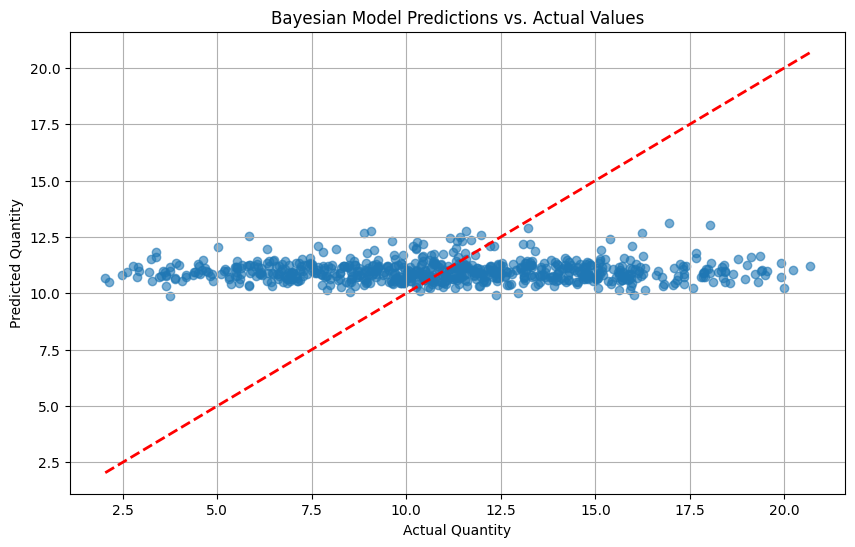

In [15]:
import matplotlib.pyplot as plt

# Scatter plot of predictions vs. actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Line of perfect prediction
plt.xlabel('Actual Quantity')
plt.ylabel('Predicted Quantity')
plt.title('Bayesian Model Predictions vs. Actual Values')
plt.grid()
plt.show()


In [18]:
# Check the groups in the InferenceData object
print("Groups in trace:", trace.groups())

# Check the variable names within the 'posterior' group
print("Variable names in posterior:", trace.posterior)


Groups in trace: ['posterior', 'sample_stats', 'observed_data']
Variable names in posterior: <xarray.Dataset> Size: 220kB
Dimensions:      (chain: 2, draw: 500, coefs_dim_0: 25)
Coordinates:
  * chain        (chain) int64 16B 0 1
  * draw         (draw) int64 4kB 0 1 2 3 4 5 6 ... 493 494 495 496 497 498 499
  * coefs_dim_0  (coefs_dim_0) int64 200B 0 1 2 3 4 5 6 ... 18 19 20 21 22 23 24
Data variables:
    intercept    (chain, draw) float64 8kB 10.01 10.01 10.01 ... 10.95 10.95
    coefs        (chain, draw, coefs_dim_0) float64 200kB 0.1048 ... 0.0553
    sigma        (chain, draw) float64 8kB 3.994 3.994 3.994 ... 3.933 3.933
Attributes:
    created_at:                 2024-10-31T13:32:17.605605+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.17.0
    sampling_time:              21.590882778167725
    tuning_steps:               500


In [20]:
# Inspect the variable names in the posterior group
posterior_vars = trace.posterior.data_vars
print("Variable names in posterior:", list(posterior_vars))



Variable names in posterior: ['intercept', 'coefs', 'sigma']


In [22]:
# Check the shape of coefficient arrays
print("Shape of Mean Coefficients:", coef_means.shape)
print("Shape of Lower CI:", coef_lower.shape)
print("Shape of Upper CI:", coef_upper.shape)


Shape of Mean Coefficients: (500, 25)
Shape of Lower CI: (500, 25)
Shape of Upper CI: (500, 25)


In [23]:
# Calculate mean and 95% credible intervals for the coefficients
coef_means = coefs_trace.mean(axis=0).flatten()  # Ensure it's 1-D
coef_lower = np.percentile(coefs_trace, 2.5, axis=0).flatten()  # Ensure it's 1-D
coef_upper = np.percentile(coefs_trace, 97.5, axis=0).flatten()  # Ensure it's 1-D


In [25]:
coefs_trace = trace.posterior['coefs'].values  # Shape: (2, 500, 25)

# Reshape to combine chains and draws: (2 * 500, 25) = (1000, 25)
coefs_flat = coefs_trace.reshape(-1, coefs_trace.shape[-1])  # Shape: (1000, 25)

# Verify the new shape
print("Shape of coefs_flat:", coefs_flat.shape)  # Should be (1000, 25)

Shape of coefs_flat: (1000, 25)


In [26]:
# Calculate mean coefficients
coef_means = coefs_flat.mean(axis=0)  # Shape: (25,)

# Calculate 95% credible intervals
coef_lower = np.percentile(coefs_flat, 2.5, axis=0)  # Shape: (25,)
coef_upper = np.percentile(coefs_flat, 97.5, axis=0)  # Shape: (25,)

# Verify the shapes
print("Shape of Mean Coefficients:", coef_means.shape)       # (25,)
print("Shape of Lower CI:", coef_lower.shape)               # (25,)
print("Shape of Upper CI:", coef_upper.shape)               # (25,)
print("Number of Features:", len(X_train.columns))          # 25



Shape of Mean Coefficients: (25,)
Shape of Lower CI: (25,)
Shape of Upper CI: (25,)
Number of Features: 25


In [27]:
# Create a DataFrame for easy visualization
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Mean Coefficient': coef_means,
    'Lower CI': coef_lower,
    'Upper CI': coef_upper
})

# Sort by absolute value of coefficients for better interpretability
coef_df['Abs Coefficient'] = coef_df['Mean Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs Coefficient', ascending=False)

# Display the top features
print("\nTop Features by Impact:")
print(coef_df[['Feature', 'Mean Coefficient', 'Lower CI', 'Upper CI']].head())



Top Features by Impact:
                        Feature  Mean Coefficient  Lower CI  Upper CI
13                  promo_price          0.129157 -0.038264  0.276229
21    competition_8_promo_price         -0.101684 -0.181950 -0.017954
8   competition_6_regular_price          0.097538  0.047300  0.170986
0                      store_id          0.097034  0.023068  0.202073
2                 regular_price         -0.077717 -0.145835  0.002855


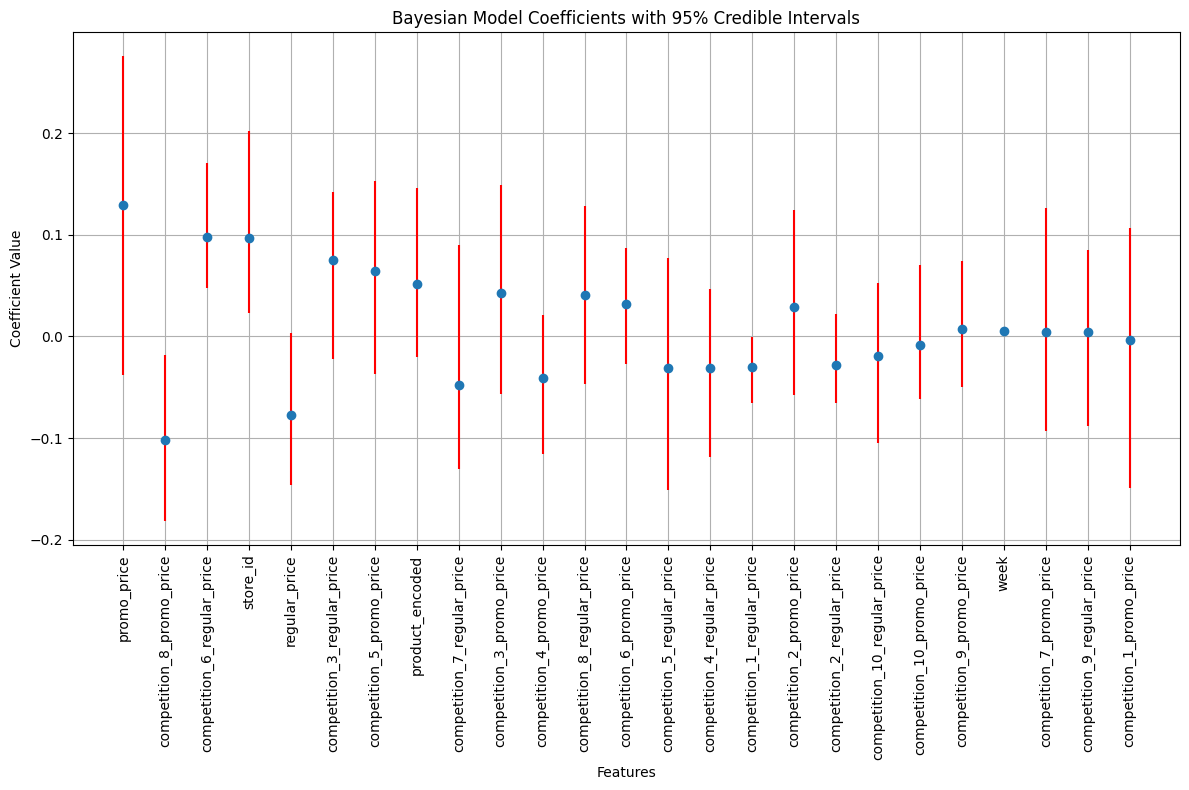

In [28]:
import matplotlib.pyplot as plt

# Plotting the coefficients with 95% credible intervals
plt.figure(figsize=(12, 8))
plt.errorbar(coef_df['Feature'], coef_df['Mean Coefficient'], 
             yerr=[coef_df['Mean Coefficient'] - coef_df['Lower CI'], 
                   coef_df['Upper CI'] - coef_df['Mean Coefficient']], 
             fmt='o', ecolor='r', capthick=2)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Bayesian Model Coefficients with 95% Credible Intervals')
plt.grid(True)
plt.tight_layout()
plt.show()
